# Ground Motion Displacement RMS vs Time

*an example simple tutorial for getting seismic data, computing the power spectral densities, extracting the RMS and plotting*

Required:

- python
- obspy (and its dependencies)
- pandas
- jupyter
- notebook

this should be easy to set up in a conda env: ``conda create -n covid python=3.7 obspy pandas jupyter notebook``

Author: Thomas Lecocq @seismotom

## Step 1: imports

In [79]:
import datetime
import os
import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.signal import PPSD


## Step 2: Define Start/End dates and Seismic Channel

You'll have to make sure the seed_id you request is indeed available from the ``data_provider``

In [43]:
start = UTCDateTime("2020-03-13")
end = UTCDateTime() # means "now"

network = "BE"
station = "UCC"
location = ""
channel = "HHZ"

data_provider = "ODC"

## Step 3: Download the seismic waveform data

This step is coded so that only the last day is redownloaded iif the daily files are present on the disk.

The request gets the target day +- 30 minutes to avoid having gaps at the end of each day (need 1 window covering midnight).

In [63]:
datelist = pd.date_range(start.datetime, end.datetime, freq="D")
c = Client("ODC")

for day in datelist:
    fn = day.strftime("%Y-%m-%d.mseed")
    print(fn)
    if day != datelist[-1] and os.path.isfile(fn):
        continue
    else:
        st = c.get_waveforms(network, station, location, channel,
                             UTCDateTime(day)-1801, UTCDateTime(day)+86400+1801, attach_response=True)
        print(st)
        st.write(fn)
resp = c.get_stations(UTCDateTime(day), network=network, station=station, location=location,
                      channel=channel, level="response")
print(resp)


2020-03-13.mseed
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-12T23:29:59.000000Z - 2020-03-14T00:30:01.000000Z | 100.0 Hz, 9000201 samples
2020-03-14.mseed
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-13T23:29:59.000000Z - 2020-03-15T00:30:01.000000Z | 100.0 Hz, 9000201 samples
2020-03-15.mseed
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-14T23:29:59.000000Z - 2020-03-16T00:30:01.000000Z | 100.0 Hz, 9000201 samples
2020-03-16.mseed
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-15T23:29:59.000000Z - 2020-03-17T00:30:01.000000Z | 100.0 Hz, 9000201 samples
2020-03-17.mseed
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-16T23:29:59.000000Z - 2020-03-18T00:30:01.000000Z | 100.0 Hz, 9000201 samples
2020-03-18.mseed
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-17T23:29:59.000000Z - 2020-03-19T00:30:01.000000Z | 100.0 Hz, 9000201 samples
2020-03-19.mseed
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-18T23:29:59.000000Z - 2020-03-20T00:30:01.000000Z | 100.0 Hz, 9000201 samples
2020-03-20.mseed
1 Trace(s)

## Step 4: Compute PPSDs using custom paramters

These parameters are set to allow the PSDs to be "nervous", not as smooth as the default PQLX ones.

In [64]:
for day in datelist:
    fn_in = day.strftime("%Y-%m-%d.mseed")
    fn_out = day.strftime("%Y-%m-%d.npz")
    if day != datelist[-1] and os.path.isfile(fn_out):
        continue
    else:    
        st = read(fn_in)
        st.attach_response(resp)
        print(st)
        ppsd = PPSD(st[0].stats, metadata=resp,
                    ppsd_length=1800, overlap=0.5,
                    period_smoothing_width_octaves=0.025,
                    period_step_octaves=0.0125,
                    period_limits=(0.008, 50),
                    db_bins=(-200, 20, 0.25))
        ppsd.add(st)
        ppsd.save_npz(fn_out[:-4])
        del st, ppsd
        
    

1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-12T23:29:59.000000Z - 2020-03-14T00:30:01.000000Z | 100.0 Hz, 9000201 samples


/home/tlecocq/miniconda3/envs/noise/lib/python3.7/site-packages/obspy/signal/spectral_estimation.py:998: RuntimeWarning: Mean of empty slice.
  smoothed_psd.append(specs.mean())
/home/tlecocq/miniconda3/envs/noise/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-13T23:29:59.000000Z - 2020-03-15T00:30:01.000000Z | 100.0 Hz, 9000201 samples
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-14T23:29:59.000000Z - 2020-03-16T00:30:01.000000Z | 100.0 Hz, 9000201 samples
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-15T23:29:59.000000Z - 2020-03-17T00:30:01.000000Z | 100.0 Hz, 9000201 samples
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-16T23:29:59.000000Z - 2020-03-18T00:30:01.000000Z | 100.0 Hz, 9000201 samples
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-17T23:29:59.000000Z - 2020-03-19T00:30:01.000000Z | 100.0 Hz, 9000201 samples
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-18T23:29:59.000000Z - 2020-03-20T00:30:01.000000Z | 100.0 Hz, 9000201 samples
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-19T23:29:59.000000Z - 2020-03-21T00:30:01.000000Z | 100.0 Hz, 9000201 samples
1 Trace(s) in Stream:
BE.UCC..HHZ | 2020-03-20T23:29:59.000000Z - 2020-03-22T00:30:01.000000Z | 100.0 Hz, 9000201 samples
1 Trace(s) in Stream:
BE

## Step 5: Reload daily PSDs from the disk and create a single PPSD object:

In [65]:
for day in datelist:
    fn = day.strftime("%Y-%m-%d.npz")
    if day == datelist[0]:
        ppsd = PPSD.load_npz(fn)
    else:
        ppsd.add_npz(fn)

/home/tlecocq/miniconda3/envs/noise/lib/python3.7/site-packages/obspy/signal/spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file '2020-03-14.npz' (time ranges already covered).
  warnings.warn(msg)
/home/tlecocq/miniconda3/envs/noise/lib/python3.7/site-packages/obspy/signal/spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file '2020-03-15.npz' (time ranges already covered).
  warnings.warn(msg)
/home/tlecocq/miniconda3/envs/noise/lib/python3.7/site-packages/obspy/signal/spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file '2020-03-16.npz' (time ranges already covered).
  warnings.warn(msg)
/home/tlecocq/miniconda3/envs/noise/lib/python3.7/site-packages/obspy/signal/spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file '2020-03-17.npz' (time ranges already covered).
  warnings.warn(msg)
/home/tlecocq/miniconda3/envs/noise/lib/python3.7/site-packages/obspy/signal/spectral_estimation.py:1539: UserWarning: 3/99 segm

## Step 6: Standard plots:

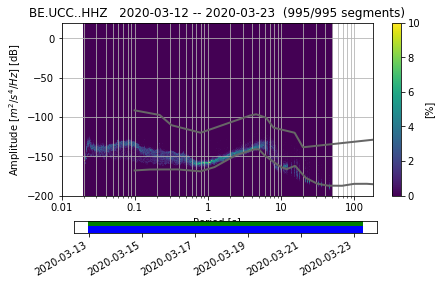

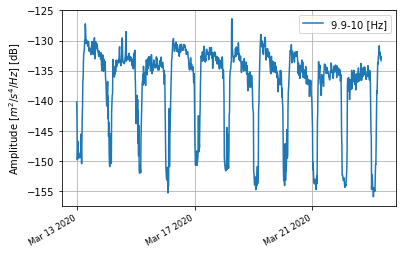

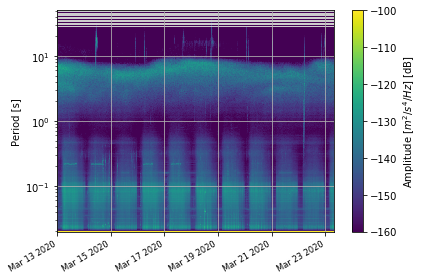

In [109]:
ppsd.plot(max_percentage=10)
ppsd.plot_temporal(0.10)
ppsd.plot_spectrogram(clim=(-160,-100))

## Step 7: Process PSDs to extract the RMS(displacement)

This can be done for multiple filters at once (``freqs`` below):

In [67]:
# Define frequency bands of interest:
freqs = [(0.1,1.0),(1.0,20.0),(4.0,14.0),(4.0,20.0)]


def rms(s, f):
    # Parseval: the RMS in time domain is the sqrt of the integral of the power spectrum
    return np.sqrt(np.trapz(s, f))

per = ppsd.period_bin_centers
displacement_RMS = []
for psd in ppsd.psd_values:
    RMS = {}
    for fmin, fmax in freqs:
        ix = np.where((per>=1.0/fmax) & (per<=1.0/fmin))

        # acceleration power spectrum in Hz
        spec = psd.copy()[ix][::-1]
        f = 1.0/per.copy()[ix][::-1]

        # remove NaNs from the list
        valid = np.where(np.isfinite(spec))[0]
        spec = spec[valid]
        f = f[valid]

        w2f = (2.0 * np.pi * f)
        
        # The acceleration amplitude spectrum (dB to Power! = divide by 10 and not 20!)
        amp = 10.0**(spec/10.) 
        
        # velocity spectrum (divide by omega**2)
        vamp = amp / w2f**2
         
        # displacement spectrum (divide by omega**2)
        damp =  vamp / w2f**2

        RMS["%.1f-%.1f"%(fmin, fmax)] = rms(damp, f)

    displacement_RMS.append(RMS)
index = pd.DatetimeIndex([d.datetime for d in ppsd.times_processed])
displacement_RMS = pd.DataFrame(displacement_RMS, index=index)

## Step 8: Custom plot for a single frequency band:

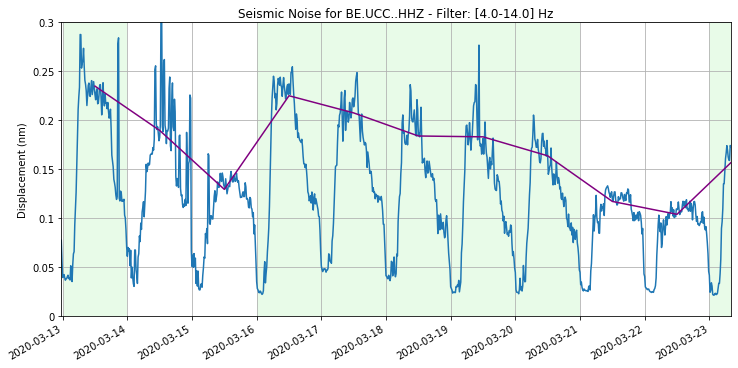

In [110]:
band = "4.0-14.0"

fig = plt.figure(figsize=(12,6))
d = displacement_RMS[band]
plt.plot(d.index, d)


# Get normal business days and set their background color to green
db = pd.bdate_range(start.datetime, end.datetime)
for dbi in db:
    plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                facecolor='lightgreen', edgecolor="none",
                alpha=0.2, zorder=-10)


rs = d.copy().between_time("6:00", "16:00")
rs = rs.resample("1D" ).mean().tshift(12, "H")
plt.plot(rs.index, rs, label="$\overline{x}$ (6h-16h)", c='purple')
    


scale = 1e9
ticks = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x*scale))
plt.gca().yaxis.set_major_formatter(ticks)
plt.ylabel("Displacement (nm)")

plt.ylim(0,0.3e-9)
plt.title('Seismic Noise for %s - Filter: [%s] Hz' % ("%s.%s.%s.%s" % (network, station, location, channel),
                                                      band))
plt.xlim(d.index.min(), d.index.max())
fig.autofmt_xdate()
plt.grid(True, zorder=-1)
plt.gca().set_axisbelow(True)
plt.show()